In [1]:
import copy
import os
import sys
import time

import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from helper import df_to_latex, fig_path, set_figsize, tab_path

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Import code from src
sys.path.insert(0, '../src/')
import vmc  # noqa

# Set plot and dataframe style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

fontsize = "large"
params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
          }

plt.rcParams.update(params)
plt.rc('text', usetex=True)

pd.set_option('display.max_columns', 50)

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

In [2]:
import matplotlib.text as mtext

class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, orig_handle, usetex=True, **self.text_props)
        handlebox.add_artist(title)
        return title

## RWM ASHONIB

INFO:RWMEvolution Initialize Random Walk Metropolis sampler with 1 chain


[Tuning progress] Chain 1:   0%|          | 0/10000 [00:00<?, ?it/s]

[Optimization progress] Chain 1:   0%|          | 0/70000 [00:00<?, ?it/s]

[Sampling progress] Chain 1:   0%|          | 0/20000 [00:00<?, ?it/s]

INFO:RWMEvolution Sampling done


Sampler elapsed time: 9.206265926361084


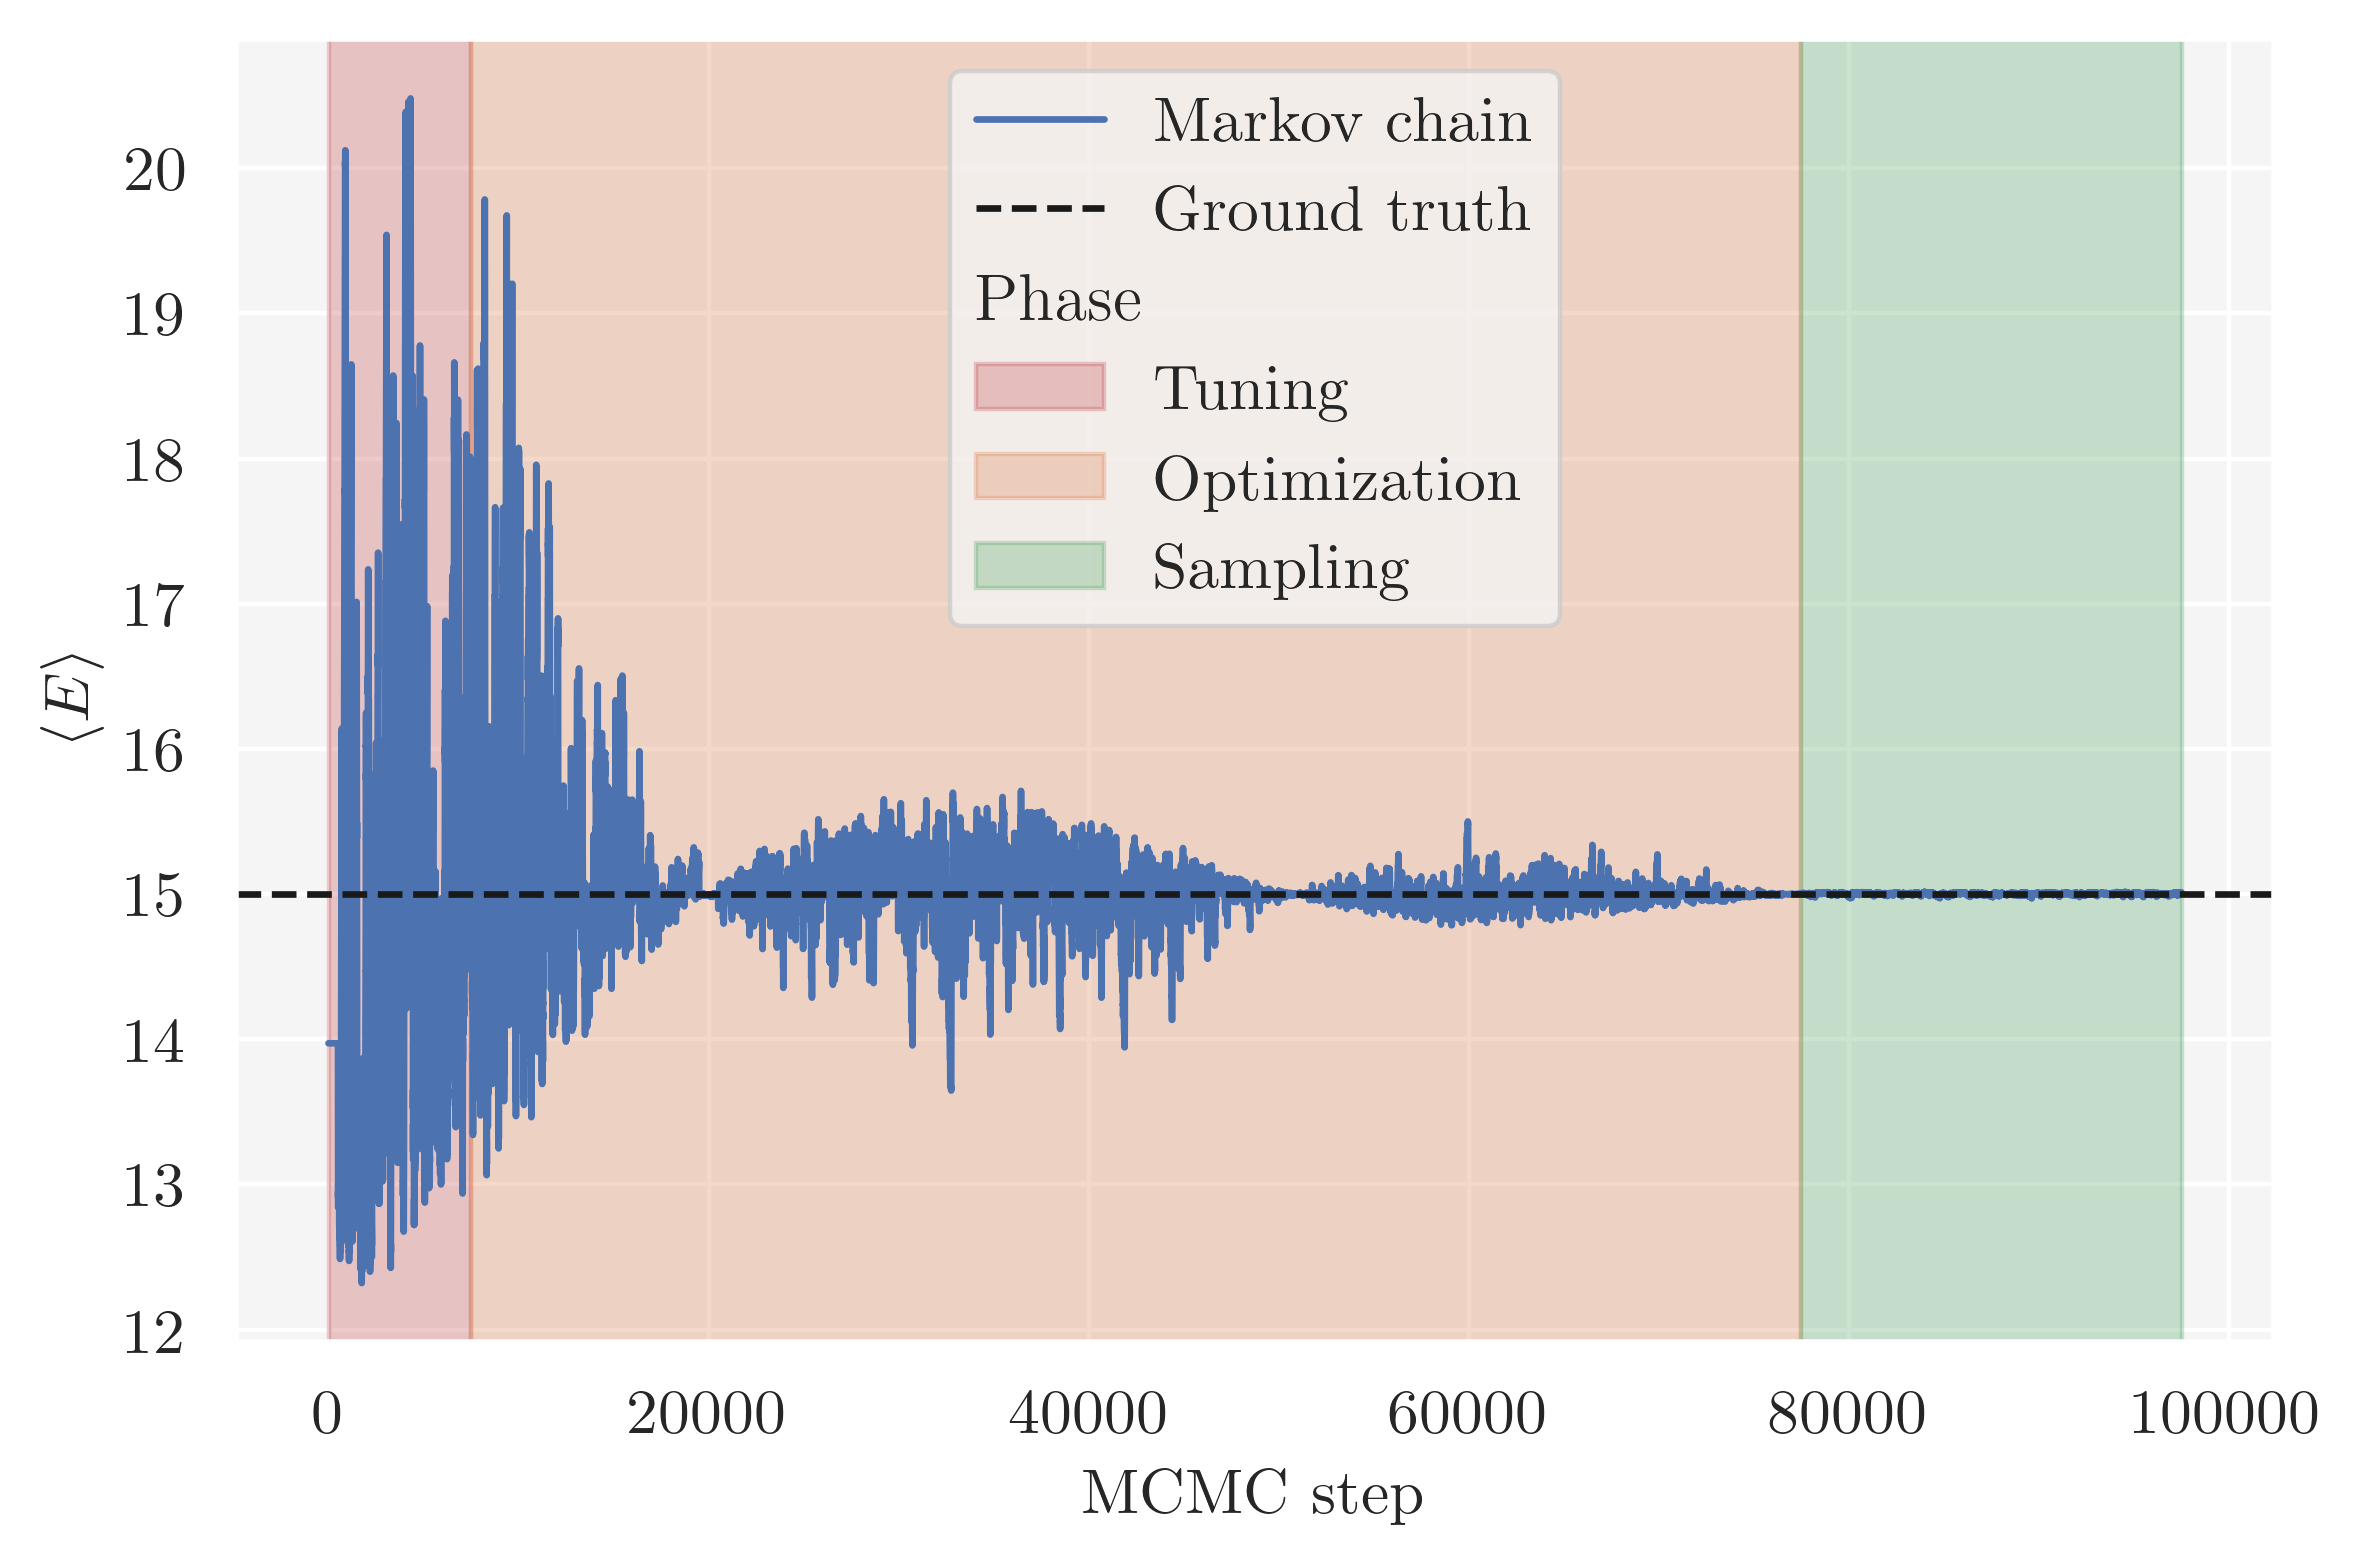

In [3]:
N = 10        # Number of particles
dim = 3      # Dimensionality

# Config
nsamples = 20000
nchains = 1
initial_alpha = 0.4

# Instantiate wave function
#wf = vmc.SHONIB(N, dim)
wf = vmc.ASHONIB(N, dim)

# Set intial positions
initial_positions = np.random.rand(N, dim)

# Instantiate sampler
sampler = vmc.experimental.RWMEvolution(wf)

start = time.time()
results = sampler.sample(nsamples,
                         initial_positions,
                         initial_alpha,
                         scale=1.0,
                         nchains=nchains,
                         seed=None,
                         tune=True,
                         tune_iter=10000,
                         tune_interval=500,
                         tol_tune=1e-5,
                         optimize=True,
                         max_iter=70000,
                         batch_size=1000,
                         gradient_method='adam',
                         eta=0.01,
                         tol_optim=1e-5,
                         early_stop=True,
                         log=True,
                         logger_level="INFO",
                         )

end = time.time()
print("Sampler elapsed time:", end - start)

df_cycles = sampler.results_all[["total_cycles", "tuning_cycles", "optimize_cycles", "nsamples"]]
df_cycles

energies = sampler.energy_samples
exact_energy = vmc.utils.exact_energy(N, dim)

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
if nchains == 1:
    ax.plot(energies, label=f'Markov chain')
else:
    for i in range(nchains):
        ax.plot(energies[i], label=f'Chain {i+1}')
ax.axhline(exact_energy, ls='--', color='k', label="Ground truth")

tuning_span = int(df_cycles["tuning_cycles"].to_numpy())
ax.axvspan(0, tuning_span, alpha=0.3, color='C3', label="Tuning")

optimize_span = tuning_span + int(df_cycles["optimize_cycles"].to_numpy())
ax.axvspan(tuning_span, optimize_span, alpha=0.3, color='C1', label="Optimization")

sampling_span = optimize_span + int(df_cycles["nsamples"].to_numpy())
ax.axvspan(optimize_span, sampling_span, alpha=0.3, color='C2', label="Sampling")

ax.set(xlabel="MCMC step",
       ylabel=r'$\langle E \rangle$')


handles, labels = ax.get_legend_handles_labels()
handles.insert(2, 'Phase')
labels.insert(2, '')
ax.legend(handles, labels, handler_map={str: LegendTitle({'fontsize': 12})})

fig.savefig(fig_path("trace_phase_rwm_ashonib.pdf"), bbox_inches='tight')

## LMH ASHONIB

INFO:LMHEvolution Initialize Langevin Metropolis-Hastings sampler with 1 chain


[Tuning progress] Chain 1:   0%|          | 0/10000 [00:00<?, ?it/s]

[Optimization progress] Chain 1:   0%|          | 0/70000 [00:00<?, ?it/s]

[Sampling progress] Chain 1:   0%|          | 0/20000 [00:00<?, ?it/s]

INFO:LMHEvolution Sampling done


Sampler elapsed time: 7.9748148918151855


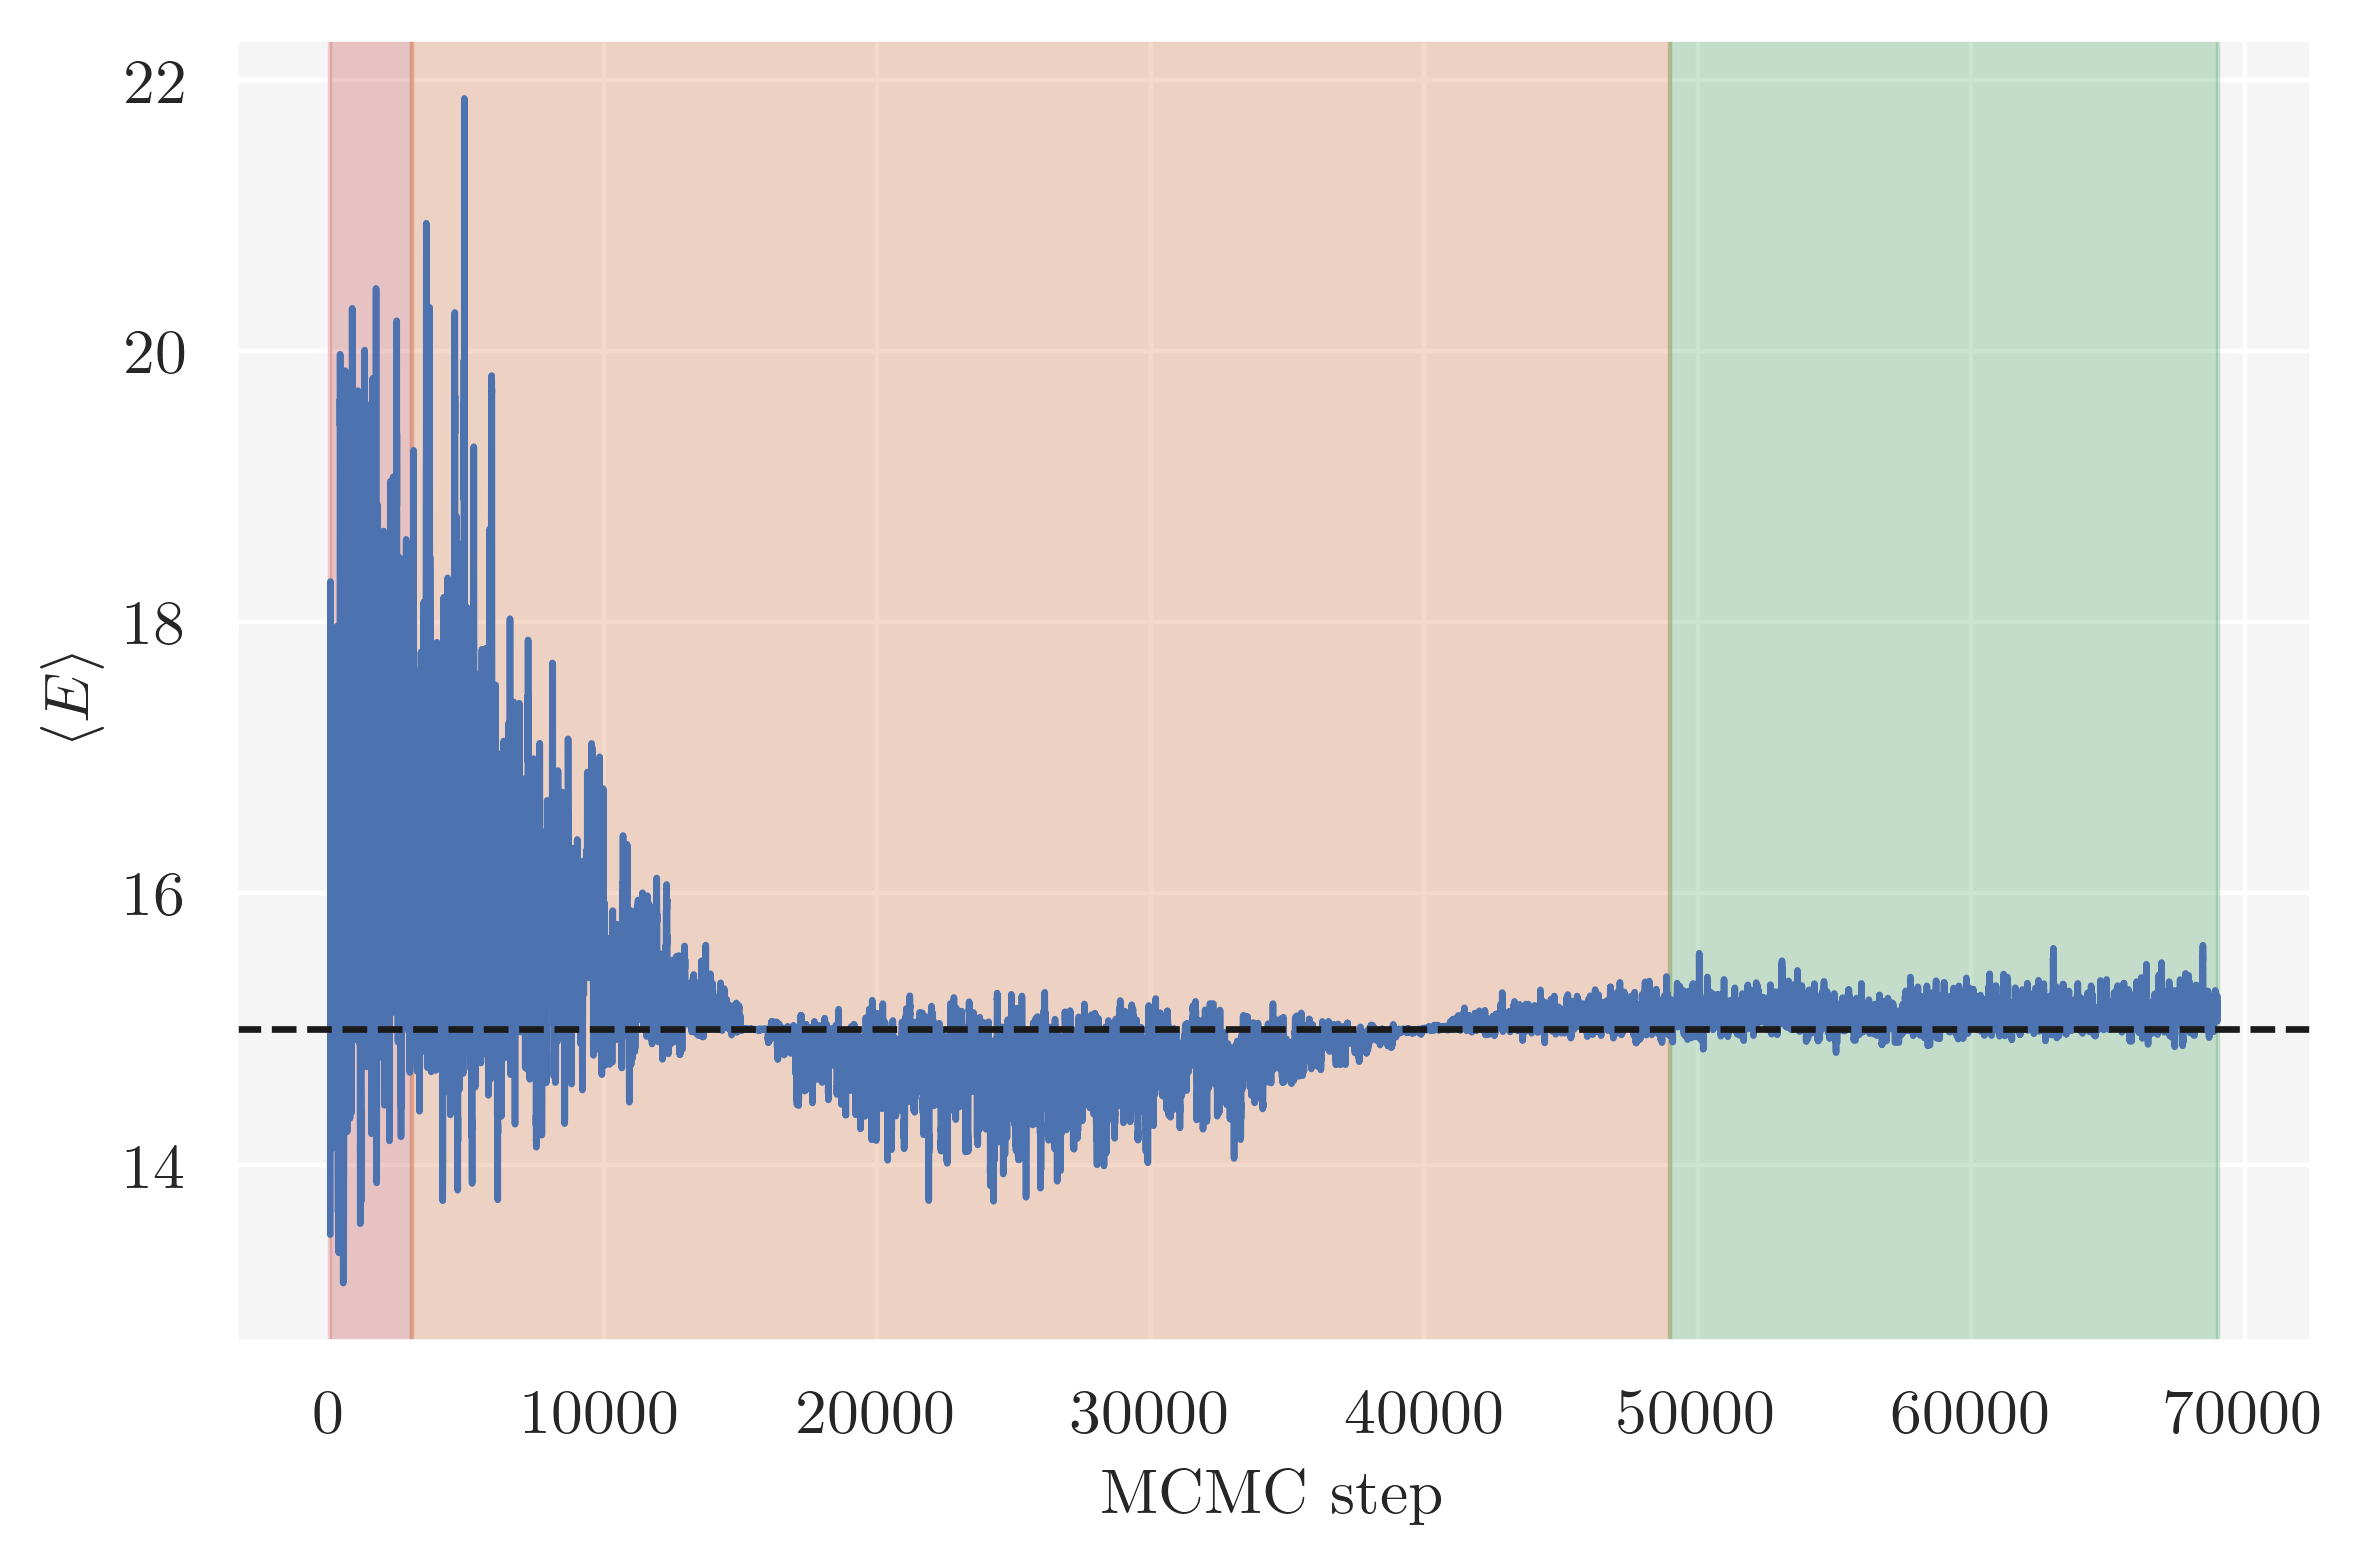

In [4]:
N = 10        # Number of particles
dim = 3      # Dimensionality

# Config
nsamples = 20000
nchains = 1
initial_alpha = 0.4

# Instantiate wave function
#wf = vmc.SHONIB(N, dim)
wf = vmc.ASHONIB(N, dim)

# Set intial positions
initial_positions = np.random.rand(N, dim)

# Instantiate sampler
sampler = vmc.experimental.LMHEvolution(wf)

start = time.time()
results = sampler.sample(nsamples,
                         initial_positions,
                         initial_alpha,
                         dt=0.5,
                         nchains=nchains,
                         seed=None,
                         tune=True,
                         tune_iter=10000,
                         tune_interval=500,
                         tol_tune=1e-5,
                         optimize=True,
                         max_iter=70000,
                         batch_size=1000,
                         gradient_method='adam',
                         eta=0.01,
                         tol_optim=1e-5,
                         early_stop=True,
                         log=True,
                         logger_level="INFO",
                         )

end = time.time()
print("Sampler elapsed time:", end - start)

df_cycles = sampler.results_all[["total_cycles", "tuning_cycles", "optimize_cycles", "nsamples"]]
df_cycles

energies = sampler.energy_samples
exact_energy = vmc.utils.exact_energy(N, dim)

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)

ax.plot(energies)

ax.axhline(exact_energy, ls='--', color='k')

tuning_span = int(df_cycles["tuning_cycles"].to_numpy())
ax.axvspan(0, tuning_span, alpha=0.3, color='C3')

optimize_span = tuning_span + int(df_cycles["optimize_cycles"].to_numpy())
ax.axvspan(tuning_span, optimize_span, alpha=0.3, color='C1')

sampling_span = optimize_span + int(df_cycles["nsamples"].to_numpy())
ax.axvspan(optimize_span, sampling_span, alpha=0.3, color='C2')

ax.set(xlabel="MCMC step",
       ylabel=r'$\langle E \rangle$')

fig.savefig(fig_path("trace_phase_lmh_ashonib.pdf"), bbox_inches='tight')

## RWM ASHOIB

INFO:RWMEvolution Initialize Random Walk Metropolis sampler with 1 chain
INFO:RWMEvolution Initialize Random Walk Metropolis sampler with 1 chain


[Tuning progress] Chain 1:   0%|          | 0/10000 [00:00<?, ?it/s]

[Optimization progress] Chain 1:   0%|          | 0/70000 [00:00<?, ?it/s]

[Sampling progress] Chain 1:   0%|          | 0/20000 [00:00<?, ?it/s]

INFO:RWMEvolution Sampling done
INFO:RWMEvolution Sampling done


Sampler elapsed time: 51.970829010009766


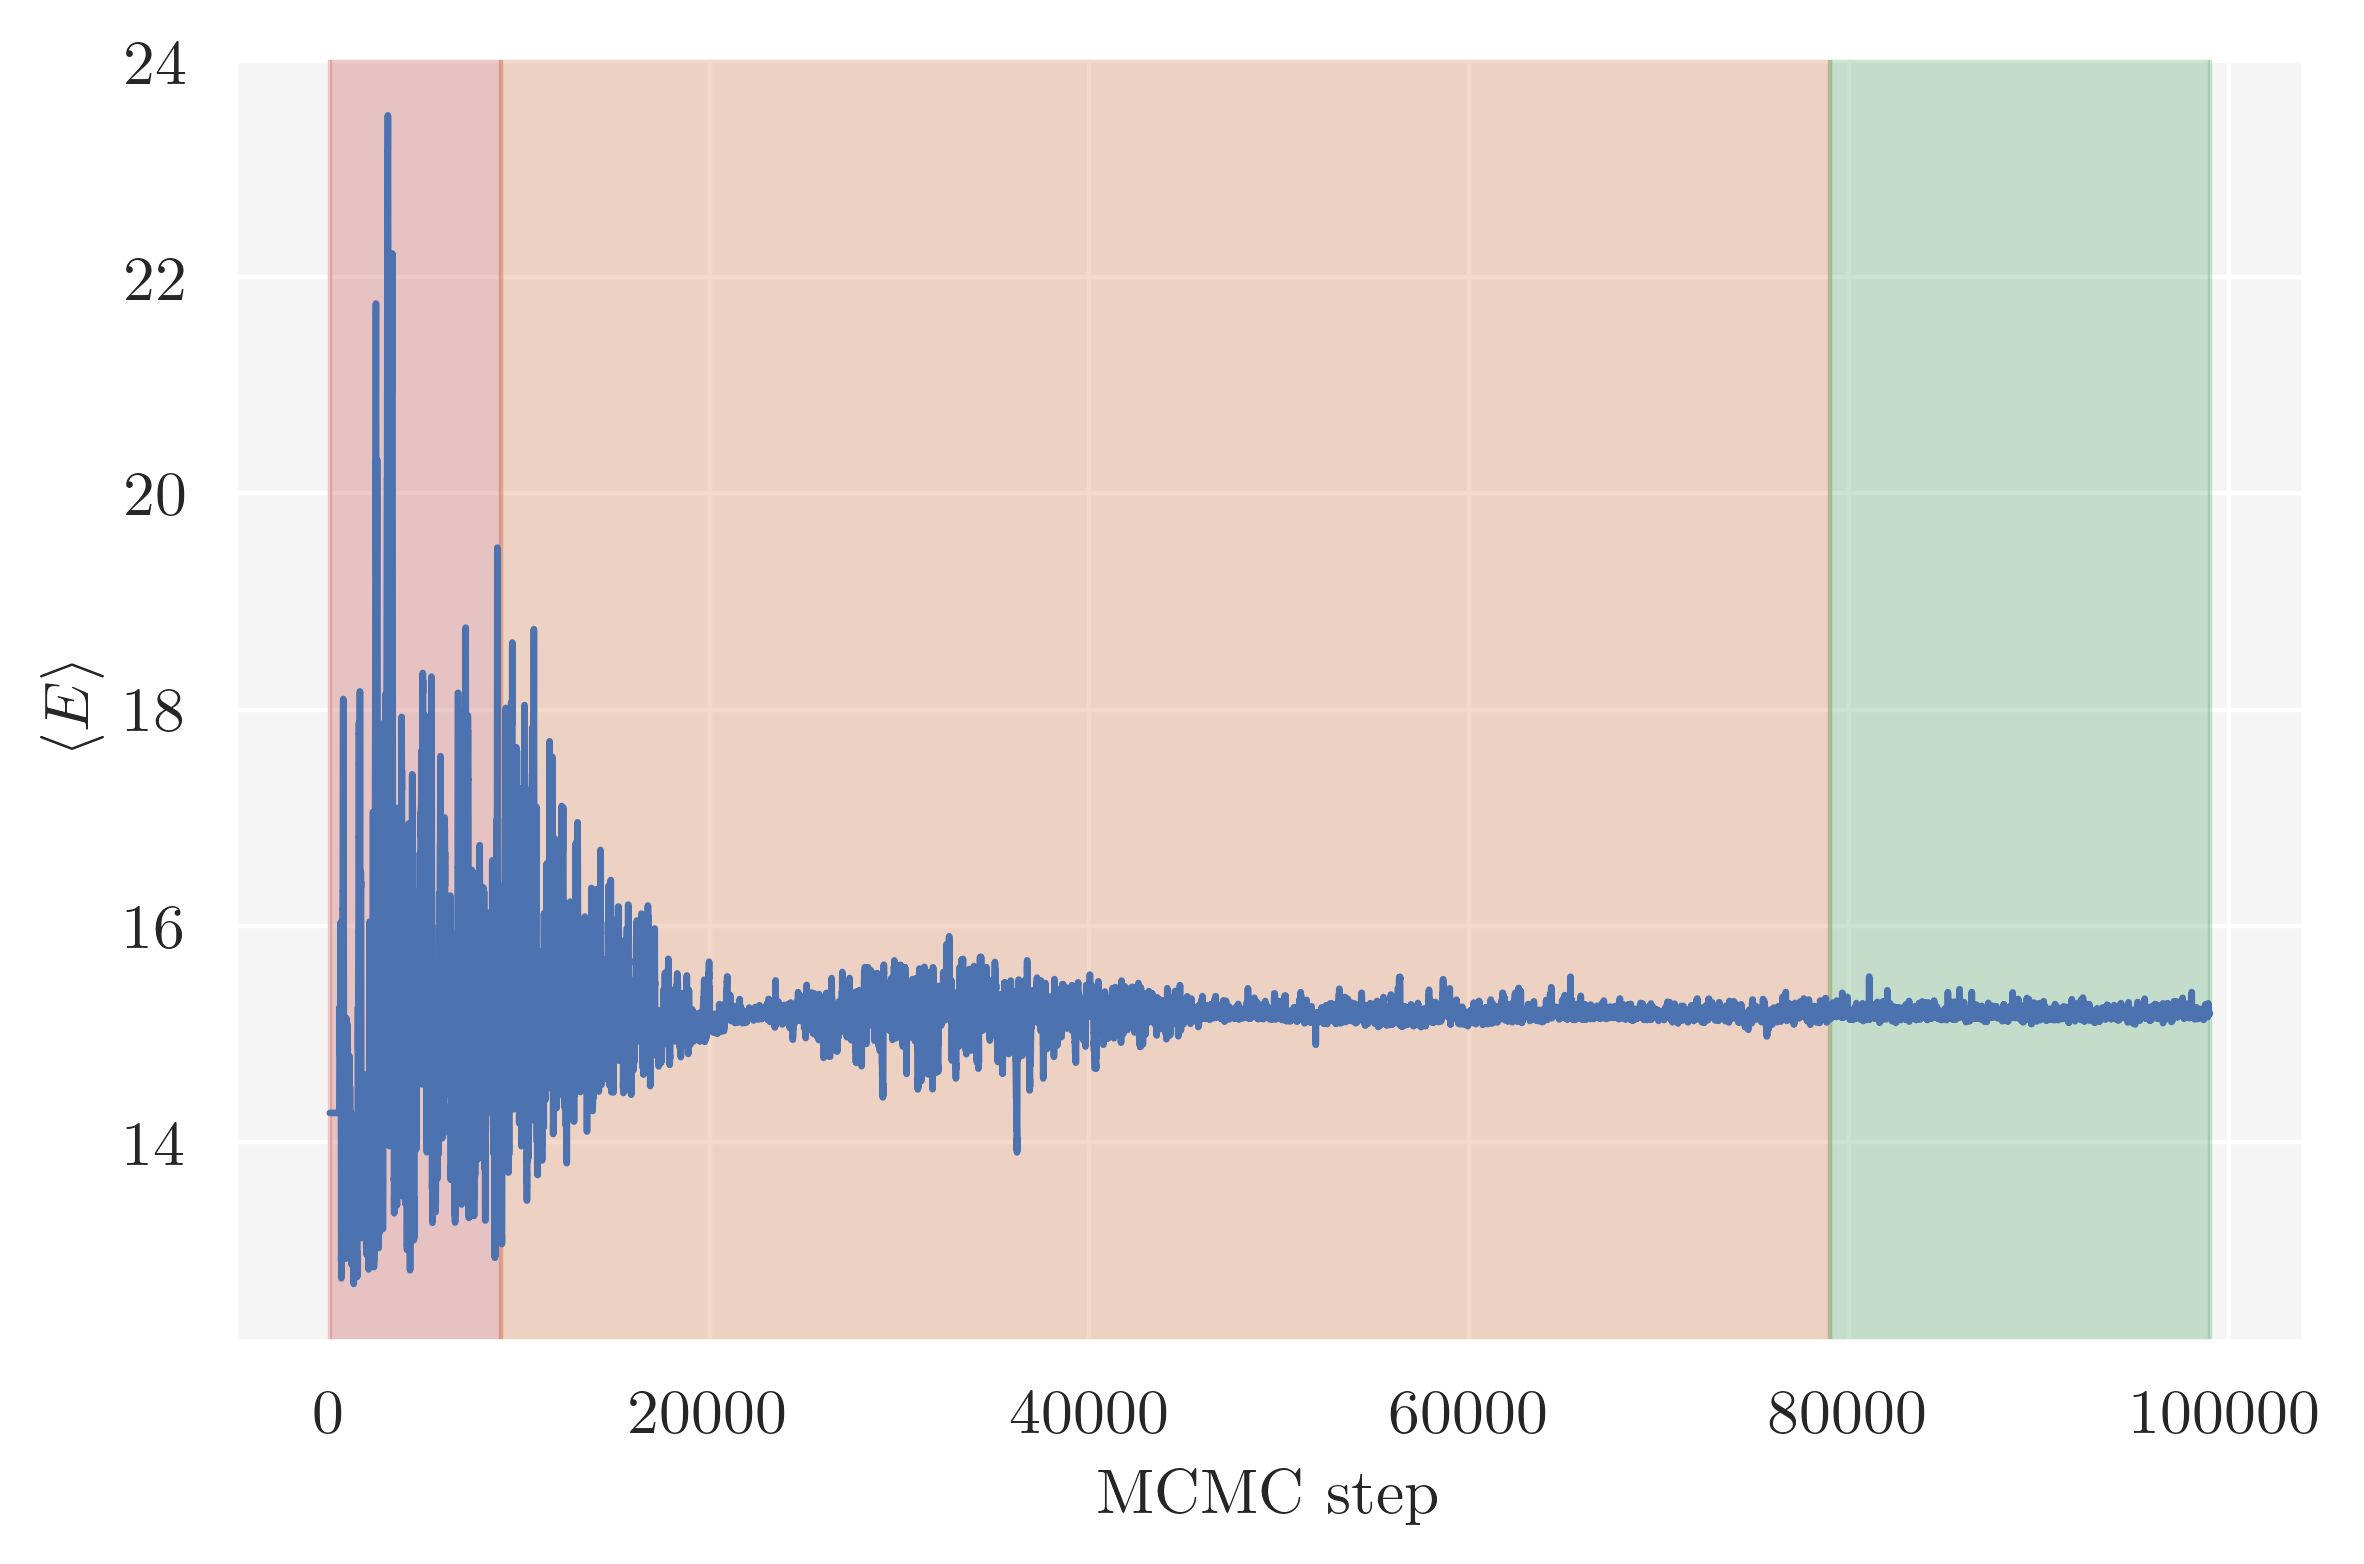

In [5]:
N = 10        # Number of particles
dim = 3      # Dimensionality

# Config
nsamples = 20000
nchains = 1
initial_alpha = 0.4

# Instantiate wave function
wf = vmc.ASHOIB(N, dim)

# Set intial positions
initial_positions = np.random.rand(N, dim)

# Instantiate sampler
sampler = vmc.experimental.RWMEvolution(wf)

start = time.time()
results = sampler.sample(nsamples,
                         initial_positions,
                         initial_alpha,
                         scale=1.0,
                         nchains=nchains,
                         seed=None,
                         tune=True,
                         tune_iter=10000,
                         tune_interval=500,
                         tol_tune=1e-5,
                         optimize=True,
                         max_iter=70000,
                         batch_size=1000,
                         gradient_method='adam',
                         eta=0.01,
                         tol_optim=1e-5,
                         early_stop=True,
                         log=True,
                         logger_level="INFO",
                         )

end = time.time()
print("Sampler elapsed time:", end - start)

df_cycles = sampler.results_all[["total_cycles", "tuning_cycles", "optimize_cycles", "nsamples"]]
df_cycles

energies = sampler.energy_samples

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)

ax.plot(energies)

tuning_span = int(df_cycles["tuning_cycles"].to_numpy())
ax.axvspan(0, tuning_span, alpha=0.3, color='C3')

optimize_span = tuning_span + int(df_cycles["optimize_cycles"].to_numpy())
ax.axvspan(tuning_span, optimize_span, alpha=0.3, color='C1')

sampling_span = optimize_span + int(df_cycles["nsamples"].to_numpy())
ax.axvspan(optimize_span, sampling_span, alpha=0.3, color='C2')

ax.set(xlabel="MCMC step",
       ylabel=r'$\langle E \rangle$')

fig.savefig(fig_path("trace_phase_rwm_ashoib.pdf"), bbox_inches='tight')

## LMH ASHOIB

INFO:LMHEvolution Initialize Langevin Metropolis-Hastings sampler with 1 chain
INFO:LMHEvolution Initialize Langevin Metropolis-Hastings sampler with 1 chain


[Tuning progress] Chain 1:   0%|          | 0/10000 [00:00<?, ?it/s]

[Optimization progress] Chain 1:   0%|          | 0/70000 [00:00<?, ?it/s]

[Sampling progress] Chain 1:   0%|          | 0/20000 [00:00<?, ?it/s]

INFO:LMHEvolution Sampling done
INFO:LMHEvolution Sampling done


Sampler elapsed time: 72.10965180397034


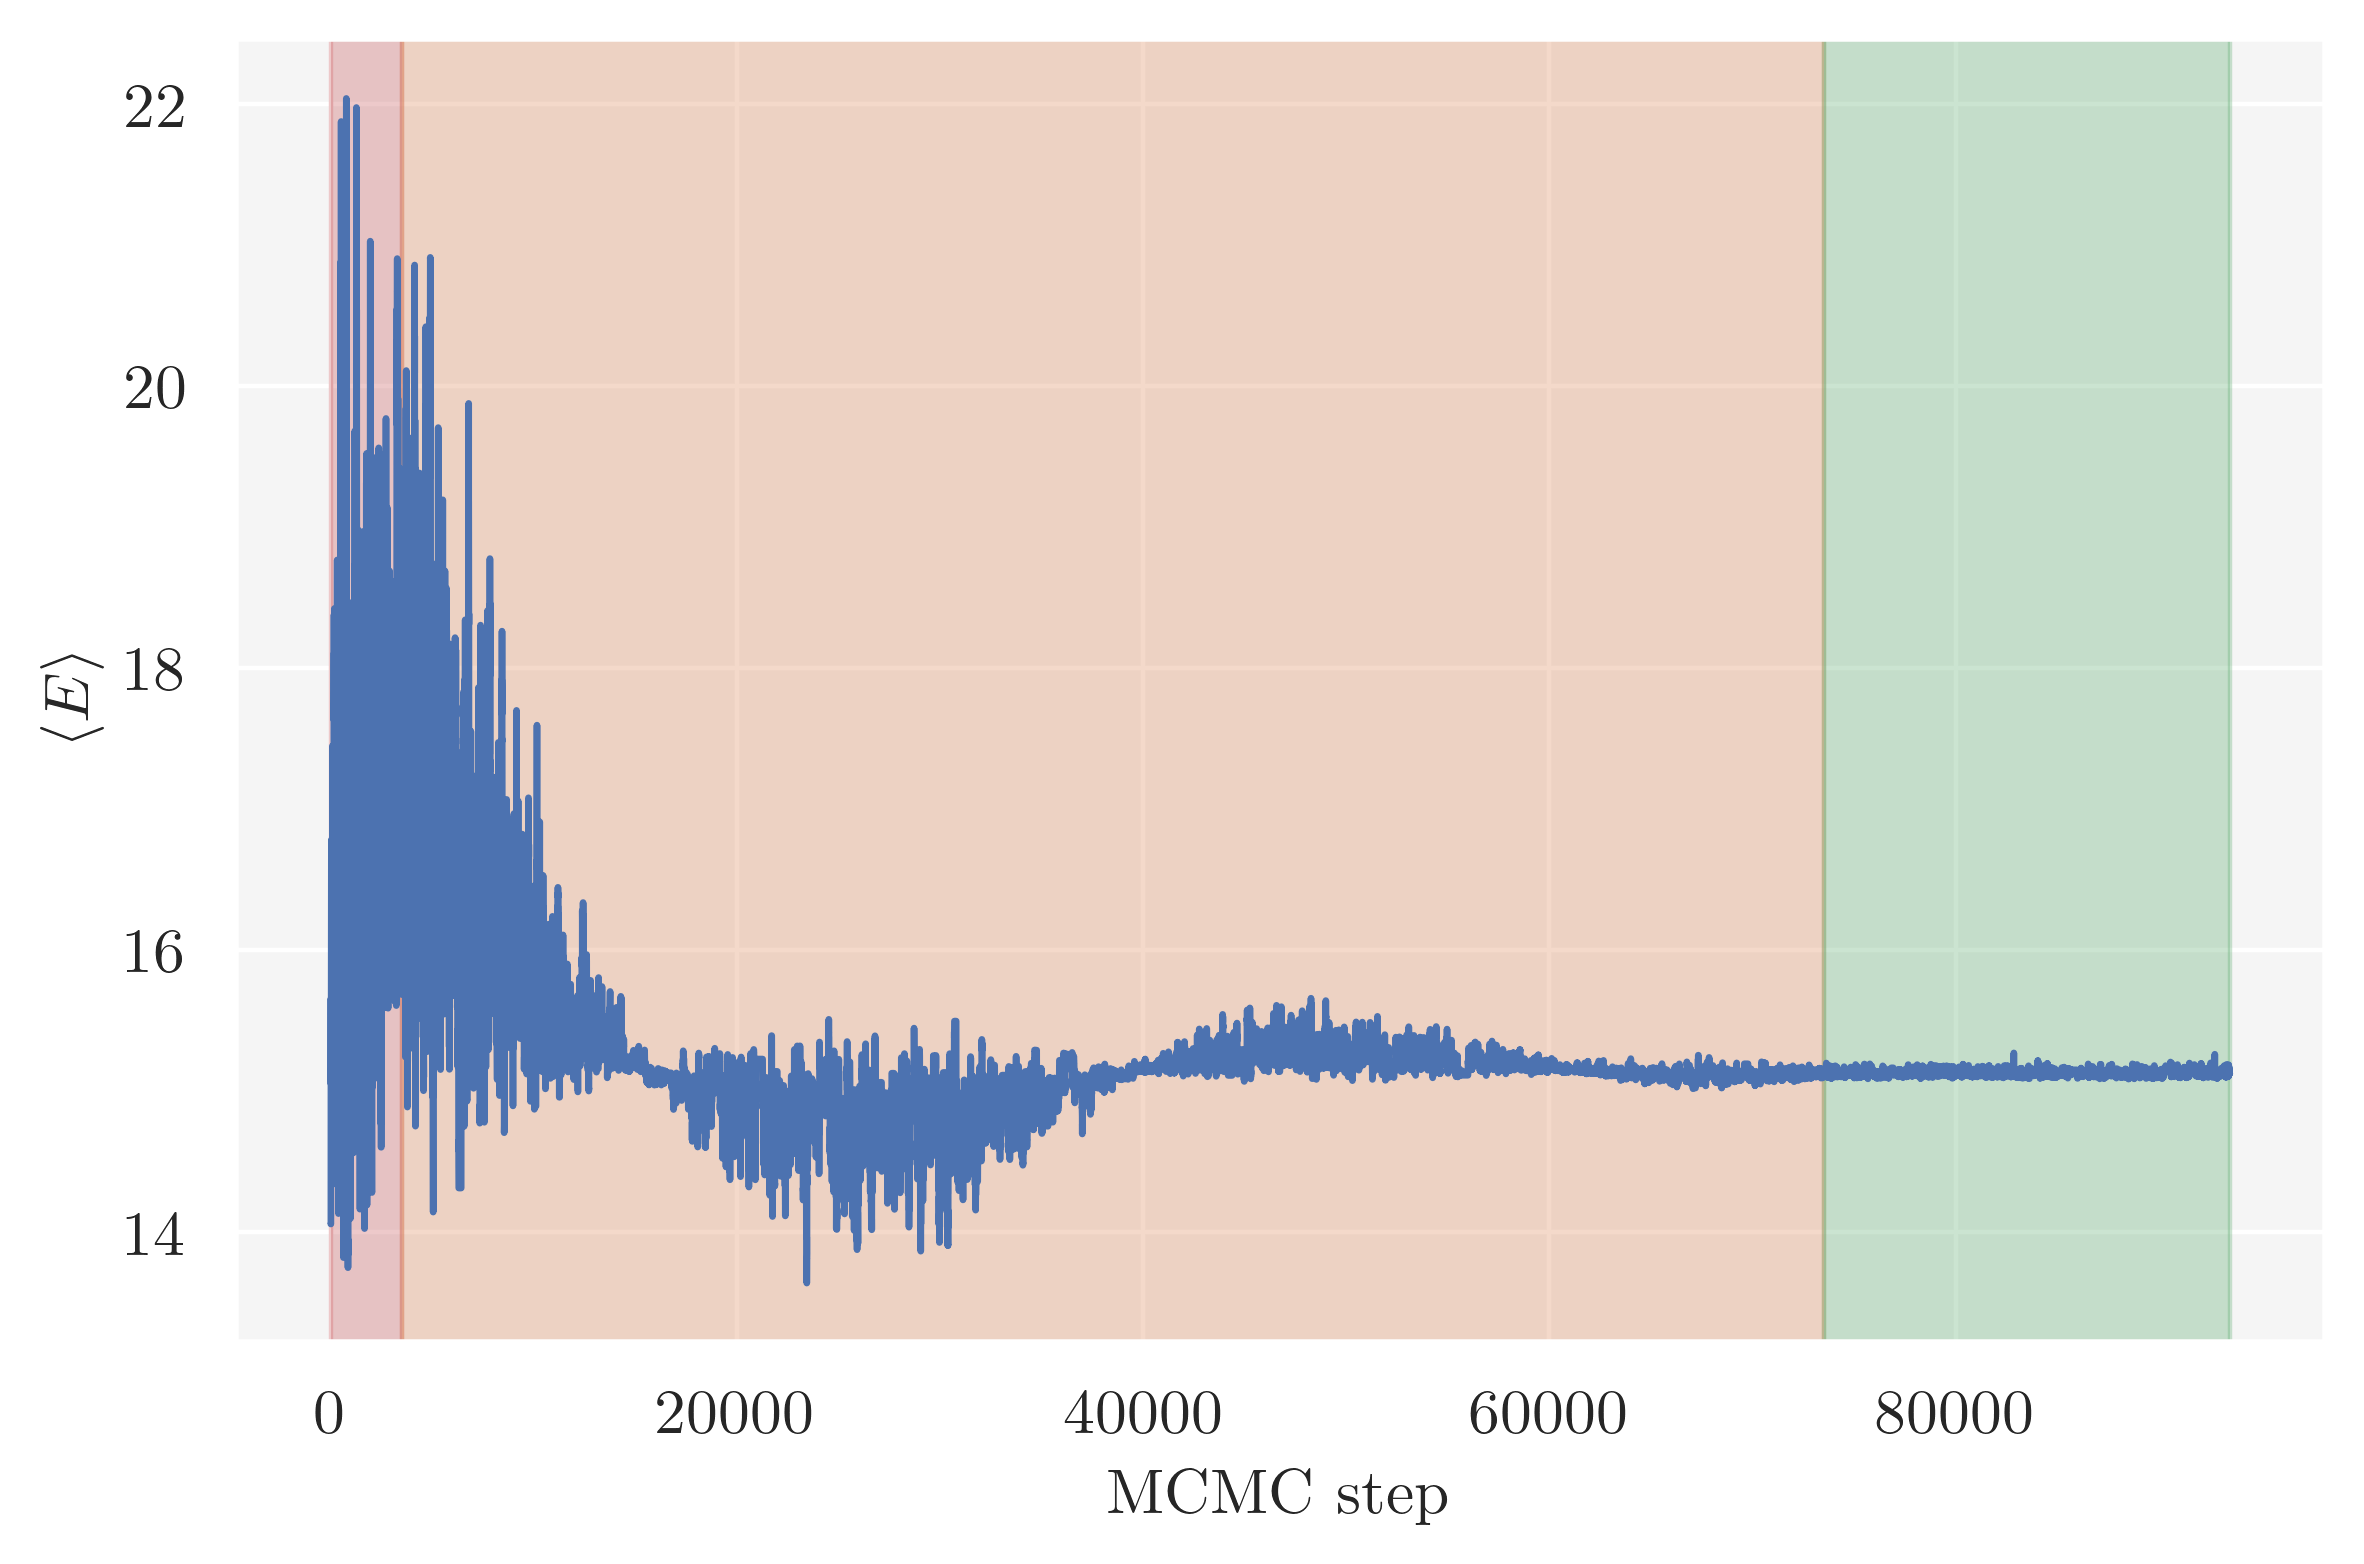

In [6]:
N = 10        # Number of particles
dim = 3      # Dimensionality

# Config
nsamples = 20000
nchains = 1
initial_alpha = 0.4

# Instantiate wave function
wf = vmc.ASHOIB(N, dim)

# Set intial positions
initial_positions = np.random.rand(N, dim)

# Instantiate sampler
sampler = vmc.experimental.LMHEvolution(wf)

start = time.time()
results = sampler.sample(nsamples,
                         initial_positions,
                         initial_alpha,
                         dt=0.5,
                         nchains=nchains,
                         seed=None,
                         tune=True,
                         tune_iter=10000,
                         tune_interval=500,
                         tol_tune=1e-5,
                         optimize=True,
                         max_iter=70000,
                         batch_size=1000,
                         gradient_method='adam',
                         eta=0.01,
                         tol_optim=1e-5,
                         early_stop=True,
                         log=True,
                         logger_level="INFO",
                         )

end = time.time()
print("Sampler elapsed time:", end - start)

df_cycles = sampler.results_all[["total_cycles", "tuning_cycles", "optimize_cycles", "nsamples"]]
df_cycles

energies = sampler.energy_samples

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)

ax.plot(energies)

tuning_span = int(df_cycles["tuning_cycles"].to_numpy())
ax.axvspan(0, tuning_span, alpha=0.3, color='C3')

optimize_span = tuning_span + int(df_cycles["optimize_cycles"].to_numpy())
ax.axvspan(tuning_span, optimize_span, alpha=0.3, color='C1')

sampling_span = optimize_span + int(df_cycles["nsamples"].to_numpy())
ax.axvspan(optimize_span, sampling_span, alpha=0.3, color='C2')

ax.set(xlabel="MCMC step",
       ylabel=r'$\langle E \rangle$')

fig.savefig(fig_path("trace_phase_lmh_ashoib.pdf"), bbox_inches='tight')